# Colab Start Section

Step 1 is to upload a copy of your private key. I am assuming your private key is named id_ed25519. If that isn't the case, you'll have to make manual changes.

In [2]:
# Change these of course to what is your email and your GitHub username
EMAIL = "pauleanderson@gmail.com"
USERNAME = "instructor"

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
%%bash -s "$EMAIL" "$USERNAME"

rm -rf /root/.ssh/*
mkdir /root/.ssh

mv id_ed25519 /root/.ssh/

chmod 600 /root/.ssh/id_ed25519

git config --global user.email "$1"
git config --global user.name "$2"

In [ ]:
%%bash -s "$USERNAME"

eval "$(ssh-agent -s)"

ssh-add ~/.ssh/id_ed25519

ssh-keyscan -t rsa github.com >> ~/.ssh/known_hosts

git clone git@github.com:anderson-fall-2024/csc-448-$1.git

# Topic 8 - Was T. Rex just a big chicken?
## Computational Proteomics

In [ ]:
!sudo chown -R $(whoami) /usr/local/lib/pkgconfig
!chmod u+w /usr/local/lib/pkgconfig
!sudo apt-get install graphviz graphviz-dev
!pip install pygraphviz

In [13]:
#### NO NEED TO EDIT ####
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.insert(0,f"csc-448-{USERNAME}")
sys.path.insert(0,"..")

from py448 import Topic8_helper

#### NO NEED TO EDIT ####

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import networkx as nx
import pandas as pd
import numpy as np
import copy
from IPython.display import Image

import matplotlib.pyplot as plt

def draw(A):
    return Image(A.draw(format='png', prog='dot'))

def to_adj(T):
    df = pd.DataFrame(nx.adjacency_matrix(T).todense(),index=T.nodes(),columns=T.nodes())
    df2 = df.copy().astype(str)
    for i in range(len(df)):
        for j in range(len(df)):
            if df.iloc[i,j] == 1:
                data = T.get_edge_data(df.index[i],df.columns[j])
                df2.iloc[i,j] = data['label']
            else:
                df2.iloc[i,j] = ""
    return df2

def show(G):
    # same layout using matplotlib with no labels
    pos = nx.drawing.nx_agraph.graphviz_layout(G, prog='neato')
    #print(edge_labels)
    # Modify node fillcolor and edge color.
    #D.node_attr.update(color='blue', style='filled', fillcolor='yellow')
    #D.edge_attr.update(color='blue', arrowsize=1)
    A = nx.nx_agraph.to_agraph(G)
    A.graph_attr["rankdir"] = "LR"
    # draw it in the notebook
    display(draw(A))

## Learning Outcomes
* Understand proteomics applications and data
* Apply, analyze, and evaluate proteomics algorithms

# Background

## Paleontology meets computing (and statistics)
Controversy ensues (make sure you note the names in the coming articles)...



* Protein sequencing was very difficult in 1950s but DNA sequencing was impossible
* Today DNA sequencing is essentially trivial while protein sequencing remains difficult
* Dinosaur drama (https://www.wired.com/2009/06/ff-originofspecies/)

<img src="https://images-na.ssl-images-amazon.com/images/I/81ZfeGANs9L._AC_SL1500_.jpg" width=400>

## Matching Ideal Spectra
This first section of exercises will allow you to implement algorithms under ideal circumstances where masses are not lost and there is no "noise" mass.

In reality... we have to deal with false and missing masses. One source of this misinformation is that when a mass spectrometer breaks a peptide, small parts of the resulting fragments may be lost, thus lowering their masses (location on the x axis). When breaking REDCA into RE, DCA, RE might lose a water molecule and DCA might lost an ammonia.

**Exercise 1**: Spectrum graph construction

We represent the masses in a spectrum as a sequence Spectrum of integers in increasing order. We define a labeled graph Graph(Spectrum) by forming a node for each element of ``spectrum``, then connecting nodes $s_i$ and $s_j$ by a directed edge labeled by an amino acid $a$ if $s_j−s_i$ is equal to the mass of $a$. We do not distinguish between amino acids having the same integer masses (i.e., the pairs K/Q and I/L). You'll need to add in a zero mass node at the beginning and the sum of all the masses as the last element.

Input: A list of integers ``spectrum``.

Output: A networkx graph that represents the graph described above.

### OK... What?

Let's break down what we know. We know the weights of amino acids

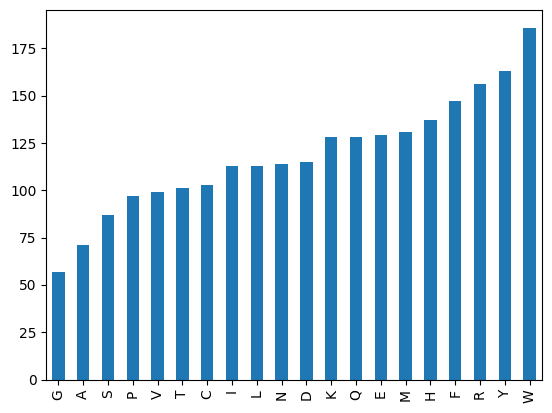

In [18]:
a_mass = {
    "G": 57,
    "A": 71,
    "S": 87,
    "P": 97,
    "V": 99,
    "T": 101,
    "C": 103,
    "I": 113,
    "L": 113,
    "N": 114,
    "D": 115,
    "K": 128,
    "Q": 128,
    "E": 129,
    "M": 131,
    "H": 137,
    "F": 147,
    "R": 156,
    "Y": 163,
    "W": 186
}
import pandas as pd
pd.Series(a_mass).plot.bar();

### We can put that information in a dictionaries that map amino acids to masses and masses to amino acids

In [19]:
import networkx as nx

mass_a = {}
for key in a_mass.keys():
    mass = a_mass[key]
    if mass not in mass_a:
        mass_a[mass] = []
    mass_a[mass].append(key)
    
pd.Series(mass_a) # Just for printing

57        [G]
71        [A]
87        [S]
97        [P]
99        [V]
101       [T]
103       [C]
113    [I, L]
114       [N]
115       [D]
128    [K, Q]
129       [E]
131       [M]
137       [H]
147       [F]
156       [R]
163       [Y]
186       [W]
dtype: object

### What about a real spectrum?
<img src="http://bioinformaticsalgorithms.com/images/Proteomics/dinosaur_spectrum_unannotated.png">

### You could take a look at a spectrum in a very simplified manner

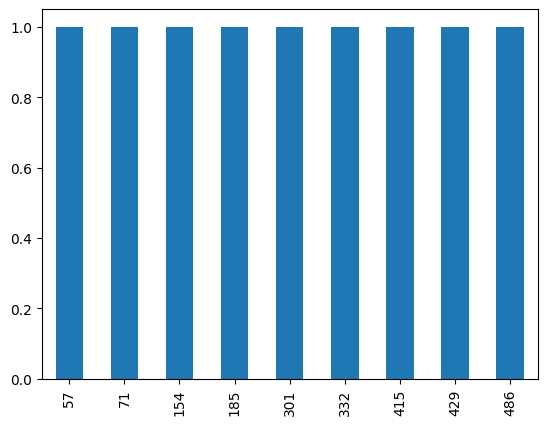

In [20]:
spectrum1 = [57,71,154,185,301,332,415,429,486]
pd.Series(1+0*np.array(spectrum1),index=spectrum1).plot.bar();

In [21]:
spectrum1 = [57,71,154,185,301,332,415,429,486]
graph1 = Topic8_helper.spectrum_graph_construction(spectrum1)

show(graph1)

,0,57,71,154,185,301,332,415,429,486
0,,G,A,,,,,,,
57,,,,P,K/Q,,,,,
71,,,,,N,,,,,
154,,,,,,F,,,,
185,,,,,,,F,,,
301,,,,,,,,N,K/Q,
332,,,,,,,,,P,
415,,,,,,,,,,A
429,,,,,,,,,,G
486,,,,,,,,,,


**Exercise 2**: Ideal spectrum

Input: A ``peptide``

Output: A list that represents the masses of the ideal spectrum

In [23]:
peptide1 = "GPG"
spectrum2 = Topic8_helper.ideal_spectrum(peptide1)
fragments = []
spectrum3 = Topic8_helper.ideal_spectrum("REDCA",fragments=fragments)

print(f"Spectrum for {peptide1}")
print(spectrum2)
print(f"Fragments for REDCA")
print(fragments)
print(f"Spectrum for REDCA")
print(spectrum3)

Spectrum for GPG
[0, 57, 57, 154, 154, 211]
Fragments for REDCA
['R', 'RE', 'RED', 'REDC', 'REDCA', 'EDCA', 'DCA', 'CA', 'A']
Spectrum for REDCA
[0, 71, 156, 174, 285, 289, 400, 418, 503, 574]


In [24]:
fragments=[]
print(Topic8_helper.ideal_spectrum('GASDGG',fragments=fragments))
print(fragments)

[0, 57, 57, 114, 128, 215, 229, 316, 330, 387, 387, 444]
['G', 'GA', 'GAS', 'GASD', 'GASDG', 'GASDGG', 'ASDGG', 'SDGG', 'DGG', 'GG', 'G']


**Exercise 3**: Decoding the ideal spectrum

Input: A ``spectrum``

Output: All matching strings representing the peptide that corresponds to a path from *source* to *sink* in Graph(spectrum) whose ideal spectrum is equal to ``spectrum``.

In [25]:
Topic8_helper.ideal_spectrum('NTDN')

[0, 114, 114, 215, 229, 330, 330, 444]

In [27]:
spectrum5 = [57,114,128,215,229,316,330,387,444]
peptides5 = Topic8_helper.decoding_ideal_spectrum(spectrum5,debug=True)

print(peptides5)

,0,57,114,128,215,229,316,330,387,444
0,,G,N,K/Q,,,,,,
57,,,G,A,,,,,,
114,,,,,T,D,,,,
128,,,,,S,T,,,,
215,,,,,,,T,D,,
229,,,,,,,S,T,,
316,,,,,,,,,A,K/Q
330,,,,,,,,,G,N
387,,,,,,,,,,G
444,,,,,,,,,,


['GGTTK', 'GGTTQ', 'GGDSK', 'GGDSQ', 'GASDN', 'GATTN', 'NTTAG', 'NDSAG', 'KSDGG', 'QSDGG', 'KTTGG', 'QTTGG']


### Again... What?

Take one of the solutions and take a look at how much it weights.

In [28]:
s=0
for c in 'GGTTQ':
    s += a_mass[c]
s

444

### But does it match the spectrum?

<pre>
spectrum5 = [57,114,128,215,229,316,330,387,444]</pre>

In [39]:
Topic8_helper.ideal_spectrum("GGTTQ")

[0, 57, 114, 128, 215, 229, 316, 330, 387, 444]

## From Ideal to Real Spectra

**Exercise 4**: Convert a peptide into a binary peptide vector.

Input: A peptide P.

Output: The peptide vector of P as a numpy array.

In [32]:
import numpy as np

peptide_v1 = Topic8_helper.construct_peptide_vector("XZZXX")

print(peptide_v1)
display(Topic8_helper.construct_peptide_vector("XZZXX",verbose=True))

[0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 1]


         0
         0
         0
X        1
         0
         0
         0
         0
XZ       1
         0
         0
         0
         0
XZZ      1
         0
         0
         0
XZZX     1
         0
         0
         0
XZZXX    1
dtype: int64

**Exercise 5**: Convert a binary vector into a peptide (do the reverse).

Input: A numpy binary vector ``p``.

Output: A peptide whose binary peptide vector matches ``p``. For masses with more than one amino acid, any choice may be used.

In [51]:
p = np.array([0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1])
peptides6 = Topic8_helper.construct_peptide_from_vector(p)

peptides6

Prefixes
[4, 9, 14, 18, 22]
Suffixes
[18, 13, 8, 4, 0]
All
[4, 4, 8, 9, 13, 14, 18, 18, 22]


['XXZZX', 'XZZXX']

**Exercise 6:** Peptide Sequencing Problem

Input: A spectral vector ``s``.

Output: A peptide with maximum score against ``s``. For masses with more than one amino acid, any choice may be used.

In [34]:
p2 = [0,0,0,4,-2,-3,-1,-7,6,5,3,2,1,9,3,-8,0,3,1,2,1,0]
peptide7 = Topic8_helper.max_peptide(p2,debug=True)

peptide7

,0:0,1:0,2:0,3:0,4:4,5:-2,6:-3,7:-1,8:-7,9:6,...,13:1,14:9,15:3,16:-8,17:0,18:3,19:1,20:2,21:1,22:0
0:0,,,,,X,Z,,,,,...,,,,,,,,,,
1:0,,,,,,X,Z,,,,...,,,,,,,,,,
2:0,,,,,,,X,Z,,,...,,,,,,,,,,
3:0,,,,,,,,X,Z,,...,,,,,,,,,,
4:4,,,,,,,,,X,Z,...,,,,,,,,,,
5:-2,,,,,,,,,,X,...,,,,,,,,,,
6:-3,,,,,,,,,,,...,,,,,,,,,,
7:-1,,,,,,,,,,,...,,,,,,,,,,
8:-7,,,,,,,,,,,...,Z,,,,,,,,,
9:6,,,,,,,,,,,...,X,Z,,,,,,,,


'XZZXX'

### So again... what?

The node labels mean something. The first integer is the mass. There is a transition between 9:6 and 13:1 because X is equal to 4 and so is 13-9. Why do we have a graph? Well. We want to score different options that are paths from this graph. How do we score? Once we have a path we can sum it up using the second integers from the nodes. So a path that went from 9:6 to 13:1 would get a score of ...+6+1+...

In [37]:
# Good job

## Test your code

In [38]:
%%bash -s "$USERNAME"

cd csc-448-$1/tests
pytest test_Topic8.py

============================= test session starts ==============================
platform darwin -- Python 3.9.6, pytest-8.3.3, pluggy-1.5.0
rootdir: /Users/pander14/GitHub/csc-448-instructor/tests
plugins: anyio-4.6.0
collected 6 items

test_Topic8.py ......                                                    [100%]

============================== 6 passed in 0.74s ===============================


## Push your code

In [34]:
%%bash -s "$USERNAME"

eval "$(ssh-agent -s)"

ssh-add ~/.ssh/id_ed25519

ssh-keyscan -t rsa github.com >> ~/.ssh/known_hosts

cd csc-448-$1
git add .
git commit -m update
git push
#./command_line_sync.sh

Agent pid 7687
On branch master
Your branch is up to date with 'origin/master'.

nothing to commit, working tree clean


Identity added: /root/.ssh/id_ed25519 (pauleanderson@gmail.com)
# github.com:22 SSH-2.0-babeld-5673f79d6
Everything up-to-date
